## 1- Libraries

In [1]:
import os
import numpy as np
import tensorflow
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import cv2
from PIL import Image

Using TensorFlow backend.


## 2- Directories

In [4]:
base_dir = '/home/jupyter/deep_learning_python/data/dogs-vs-cats/small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## 3- Instantating VGG16 convent

In [5]:
conv_base = VGG16(
  weights = 'imagenet',
  include_top = False,
  input_shape = (150, 150, 3)
)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## 4- Ways of proceed

At this point there are two ways of proceed:

* Fast feature extraction without data augmentation
* Feature extraction with data augmentation

### 4.1 Fast feature extraction

#### 4.1.1- Extraction 

In [5]:
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

In [6]:
def extract_features(directory, sample_count):
    features = np.zeros(
        shape = (sample_count, 4, 4, 512)
      )
    labels = np.zeros(shape = (sample_count))

    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary'
      )
  
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


In [8]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


In [9]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


#### 4.1.2- Reshape

In [10]:
train_features = np.reshape(train_features, (2000, 4* 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4* 4 * 512))
test_features =  np.reshape(test_features, (1000, 4* 4 * 512))

#### 4.1.3- Definig and training the densely connected classifier

In [1]:
model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

NameError: name 'models' is not defined

In [14]:
model.compile(
  optimizer = optimizers.RMSprop(lr = 2e-5),
  loss = 'binary_crossentropy',
  metrics = ['acc']
)

In [15]:
history = model.fit(
  train_features,
  train_labels,
  epochs = 30,
  batch_size = 20,
  validation_data = (validation_features, validation_labels)
)

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 925us/step - loss: 0.5824 - acc: 0.6825 - val_loss: 0.4332 - val_acc: 0.8400
Epoch 2/30
2000/2000 [==============================] - 1s 407us/step - loss: 0.4222 - acc: 0.8120 - val_loss: 0.3617 - val_acc: 0.8560
Epoch 3/30
2000/2000 [==============================] - 1s 400us/step - loss: 0.3627 - acc: 0.8475 - val_loss: 0.3246 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 1s 398us/step - loss: 0.3108 - acc: 0.8660 - val_loss: 0.3034 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 1s 395us/step - loss: 0.2911 - acc: 0.8770 - val_loss: 0.2856 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 1s 410us/step - loss: 0.2654 - acc: 0.8930 - val_loss: 0.2776 - val_acc: 0.8920
Epoch 7/30
2000/2000 [==============================] - 1s 407us/step - loss: 0.2475 - a

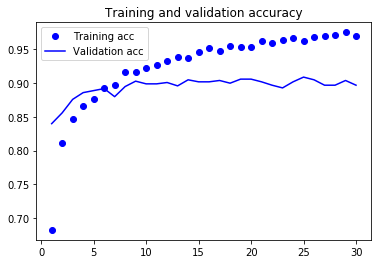

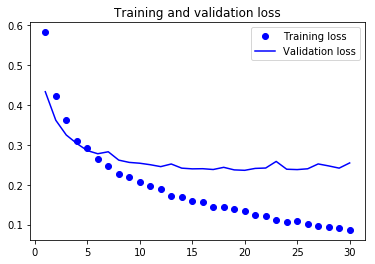

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

### 4.2 Feature extraction with data augmentation

#### 4.2.1 Adding a densely connected classifier on top of the convolutional base

In [18]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

#### 4.2.2 Training the model

In [19]:
print("This is the number of trainable weights before freezing the base " + str(len(model.trainable_weights)))
conv_base.trainable = False
print("This is the number of trainable weights after freezing the base " + str(len(model.trainable_weights)))

This is the number of trainable weights before freezing the base 4
This is the number of trainable weights after freezing the base 4


In [20]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)


model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.RMSprop(lr = 2e-5),
    metrics = ['acc']
)

history = model.fit_generator(
   train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 28s 284ms/step - loss: 0.5901 - acc: 0.7005 - val_loss: 0.4569 - val_acc: 0.8230
Epoch 2/30
100/100 [==============================] - 27s 270ms/step - loss: 0.4871 - acc: 0.7805 - val_loss: 0.3795 - val_acc: 0.8540
Epoch 3/30
100/100 [==============================] - 27s 266ms/step - loss: 0.4388 - acc: 0.8055 - val_loss: 0.3433 - val_acc: 0.8640
Epoch 4/30
100/100 [==============================] - 27s 268ms/step - loss: 0.4053 - acc: 0.8240 - val_loss: 0.3088 - val_acc: 0.8830
Epoch 5/30
100/100 [==============================] - 26s 262ms/step - loss: 0.3821 - acc: 0.8360 - val_loss: 0.2925 - val_acc: 0.8860
Epoch 6/30
100/100 [==============================] - 27s 269ms/step - loss: 0.3796 - acc: 0.8385 - val_loss: 0.2816 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 27s 268ms/step - loss: 0.3699 - acc: 0.8225 - val_lo

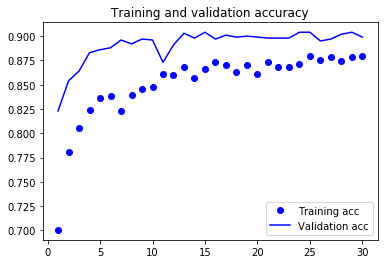

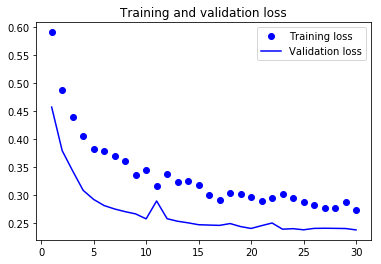

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### 4.2.3 Prediction

In [150]:
folder = '/home/jupyter/deep_learning_python/data/dogs-vs-cats/small/to_test'
print(folder)

/home/jupyter/deep_learning_python/data/dogs-vs-cats/small/to_test


In [151]:
img = Image.open(os.path.join(folder, 'images', 'cat.09.jpg'))
img = img.resize((150,150))
img = np.asarray(img)
img = img.astype('float32')
img = img * 1.0/255
img = np.reshape(img,(1,150,150,3))

In [152]:
classes = model.predict_classes(img)
classes2 = model.predict(img)
print classes
print classes2

[[0]]
[[0.319096]]


In [153]:
test_datagen2 = ImageDataGenerator(
    rescale = 1./255
)

test_generator2 = test_datagen2.flow_from_directory(
    folder,
    target_size = (150, 150),
    batch_size = 2,
    class_mode = 'binary',
    shuffle = False
)
test_generator2.reset()
pred = model.predict_generator(test_generator2, steps = 1)
filenames = test_generator2.filenames

Found 2 images belonging to 2 classes.


In [147]:
pred_list = np.squeeze(pred)
pred_list = pred_list.tolist()

In [148]:
results=pd.DataFrame({
    "Filename":filenames,
    "Predictions":pred_list
})
#print(results.head())
#print(results.tail())
print(results)

            Filename  Predictions
0  images/cat.09.jpg     0.319096
1  images/cat.10.jpg     0.052839


### 4.3 Fine-tuning

We are going to to fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozeen.

Note that we use the model trained in section 4.2 Feature extraction with data augmentation. The steps to perform fine tuning are the following ones:
* Load the model (VGG16).
* Add the custom network on top of VGG16.
* Freeze the base network.
* Train the part we added.
* Unfreeze some layers in the base network.
* Jointly train both these layers and the part we added.

In [22]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [23]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_con1':
        set_trainable = True
    
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.RMSprop(lr = 1e-5),
    metrics = ['acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 50
)

Epoch 1/100
100/100 [==============================] - 29s 286ms/step - loss: 0.2838 - acc: 0.8820 - val_loss: 0.2455 - val_acc: 0.9020
Epoch 2/100
100/100 [==============================] - 27s 266ms/step - loss: 0.2850 - acc: 0.8815 - val_loss: 0.2318 - val_acc: 0.9020
Epoch 3/100
100/100 [==============================] - 27s 269ms/step - loss: 0.2856 - acc: 0.8835 - val_loss: 0.2447 - val_acc: 0.8930
Epoch 4/100
100/100 [==============================] - 27s 267ms/step - loss: 0.2604 - acc: 0.8860 - val_loss: 0.2268 - val_acc: 0.9030
Epoch 5/100
100/100 [==============================] - 27s 267ms/step - loss: 0.2899 - acc: 0.8730 - val_loss: 0.2365 - val_acc: 0.9050
Epoch 6/100
100/100 [==============================] - 26s 261ms/step - loss: 0.2709 - acc: 0.8915 - val_loss: 0.2389 - val_acc: 0.8920
Epoch 7/100
100/100 [==============================] - 26s 263ms/step - loss: 0.2718 - acc: 0.8835 - val_loss: 0.2534 - val_acc: 0.9040
Epoch 8/100
100/100 [===========================

In [35]:
def smooth_curve(points, factor = 0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return(smoothed_points)

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

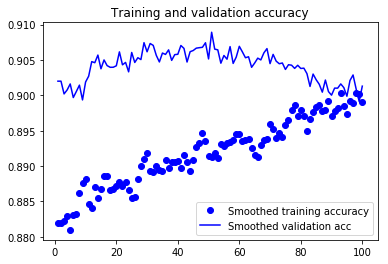

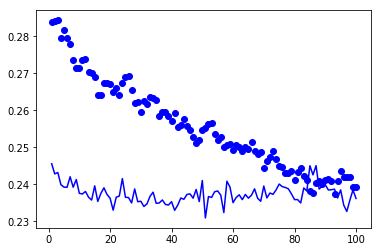

In [40]:
plt.plot(
    epochs,
    smooth_curve(acc),
    'bo',
    label = 'Smoothed training accuracy'
)



plt.plot(
    epochs,
    smooth_curve(val_acc),
    'b',
    label = 'Smoothed validation acc'
)

plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(
    epochs,
    smooth_curve(loss),
    'bo',
    label = 'Smoothed training loss'
)

plt.plot(
    epochs,
    smooth_curve(val_loss),
    'b',
    label = 'Smoothed validation loss'
)

In [41]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

tet_loss, test_acc = model.evaluate_generator(
    test_generator,
    steps = 50
)

print(test_acc)

Found 1000 images belonging to 2 classes.
0.8999999952316284
